In [ ]:
# Importing necessary modules
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from keras.optimizers import AdamW

Loading and splitting the data.

In [ ]:
 (train_set, valid_set, test_set), (data_info)  = tfds.load(
    name="eurosat",
    split=["train[:70%]", "train[70%:85%]", "train[85%:]"],
    as_supervised=True,
    shuffle_files = True,
    with_info = True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/eurosat/rgb/2.0.0.incompleteUX97ZS/eurosat-train.tfrecord*...:   0%|      …

Dataset eurosat downloaded and prepared to /root/tensorflow_datasets/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.


In [ ]:
train_set

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
valid_set

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

Checking the sizes of train, validataion and test sets.

In [ ]:
print(train_set.cardinality().numpy())

18900


In [ ]:
print(valid_set.cardinality().numpy())

4050


In [ ]:
print(test_set.cardinality().numpy())

4050


Getting information about our dataset.
There are 27000 images overall and 10 classes.

In [ ]:
data_info

tfds.core.DatasetInfo(
    name='eurosat',
    full_name='eurosat/rgb/2.0.0',
    description="""
    EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
    bands and consisting of 10 classes with 27000 labeled and
    geo-referenced samples.
    
    Two datasets are offered:
    - rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
    - all: Contains all 13 bands in the original value range (float32).
    
    URL: https://github.com/phelber/eurosat
    """,
    config_description="""
    Sentinel-2 RGB channels
    """,
    homepage='https://github.com/phelber/eurosat',
    data_dir=PosixGPath('/tmp/tmpyi_v3ufhtfds'),
    file_format=tfrecord,
    download_size=89.91 MiB,
    dataset_size=89.50 MiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=string),
        'image': Image(shape=(64, 64, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('ima

Image examples from train and validation sets

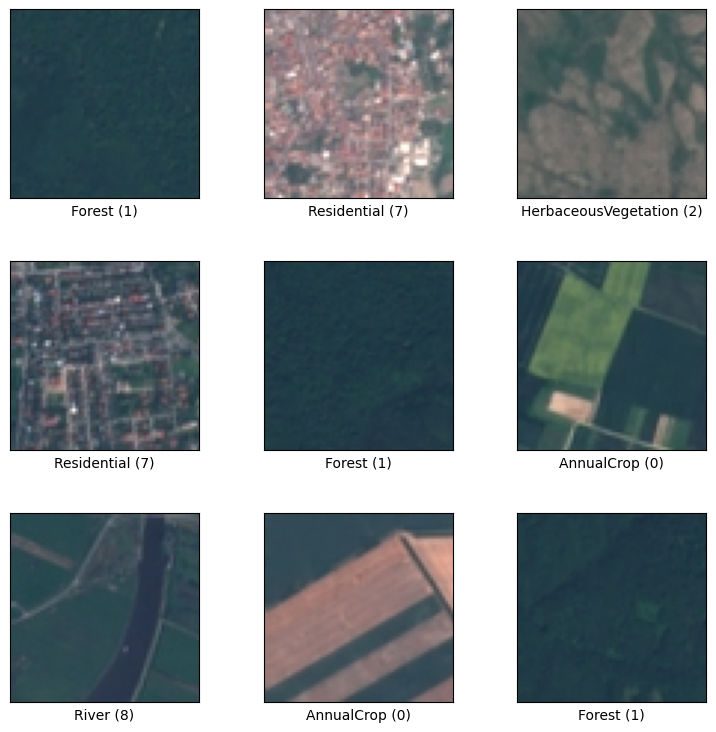

In [ ]:
fig = tfds.show_examples(train_set, tfds.builder('eurosat').info)

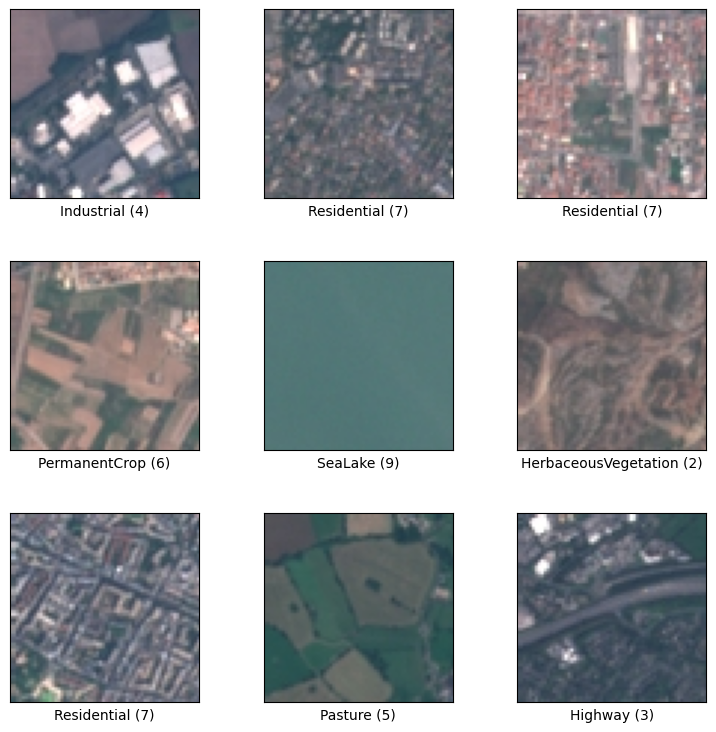

In [ ]:
fig2 = tfds.show_examples(valid_set, tfds.builder('eurosat').info)

Data Preparation

In [ ]:
# A function which changes the resolutions of the images and rescales all pixel values to be between 0 and 1
# One can also change the data type into float16 on a larger dataset to save memmory, but for this one it's not necessary.
image_size = (64, 64)
def normalize(image, label):
    normalized_image = tf.image.resize(image, image_size)
    normalized_image /= 255
#    normalized_image = tf.cast(normalized_image, tf.float16)
    return normalized_image, label

In [ ]:
# Normalizing the images as described before and dividing them into batches, we will also shuffle the training set
train_set = train_set.shuffle(30_000, seed=42).map(normalize).batch(32, drop_remainder=True).prefetch(1)
valid_set = valid_set.map(normalize).batch(32, drop_remainder=True).cache().prefetch(1)
test_set = test_set.map(normalize).batch(32, drop_remainder=True).cache().prefetch(1)
tf.random.set_seed(42)

# Building the model.

Adding more dense layers made the performance of the network worse.
I tried 5 different values for dropout rate (0.25, 0.375, 0.5, 0.625, 0.75) and the 1 with 0.375 performed the best.

I also used early stopping for regularization.
By default early stopping monitors the validation loss, but changing it to validation accuracy improves the score.

In [ ]:
# A convolutional neural network
tf.random.set_seed(42)
model = Sequential()
model.add(Conv2D(input_shape=(64, 64, 3), filters=32,activation='relu',
                 kernel_size=(3,3),padding='same'
                 ))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=64,activation='relu',
                 kernel_size=(3,3),padding='same'
                 ))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=128,activation='relu',
                 kernel_size=(3,3),padding='same'
                 ))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=256,activation='relu',
                 kernel_size=(3,3),padding='same'
                 ))
model.add(tf.keras.layers.GlobalAvgPool2D())
# model.add(Flatten()) # One also can use flatten instead of globalavgpool2d
model.add(tf.keras.layers.Dropout(0.375)),
# model.add(Dense(256, activation='relu')),
# model.add(tf.keras.layers.Dropout(0.8)),
# model.add(Dense(128, activation='relu')),
# model.add(tf.keras.layers.Dropout(0.5)),
model.add(Dense(10, activation='softmax'))

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_checkpoints",
                                                   save_weights_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience=25,
                                                     restore_best_weights=True)

In [ ]:
train_set

<_PrefetchDataset element_spec=(TensorSpec(shape=(32, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(32,), dtype=tf.int64, name=None))>

Compiling the model

In [ ]:
# I used the AdamW optimizer
optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-3)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 8, 8, 128)         0

Training and evaluating the model.

In [ ]:
history = model.fit(train_set, epochs=250,
                    validation_data=(valid_set), callbacks=[checkpoint_cb, early_stopping_cb])
score = model.evaluate(test_set)

Epoch 1/250
590/590 [==============================] - 20s 9ms/step - loss: 1.3777 - accuracy: 0.4581 - val_loss: 1.0162 - val_accuracy: 0.6193
Epoch 2/250
590/590 [==============================] - 5s 7ms/step - loss: 0.9420 - accuracy: 0.6588 - val_loss: 0.7823 - val_accuracy: 0.7121
Epoch 3/250
590/590 [==============================] - 5s 7ms/step - loss: 0.7668 - accuracy: 0.7242 - val_loss: 0.6403 - val_accuracy: 0.7750
Epoch 4/250
590/590 [==============================] - 5s 8ms/step - loss: 0.6991 - accuracy: 0.7478 - val_loss: 0.5719 - val_accuracy: 0.7892
Epoch 5/250
590/590 [==============================] - 5s 7ms/step - loss: 0.6468 - accuracy: 0.7698 - val_loss: 0.5787 - val_accuracy: 0.7860
Epoch 6/250
590/590 [==============================] - 5s 8ms/step - loss: 0.5917 - accuracy: 0.7876 - val_loss: 0.5124 - val_accuracy: 0.8172
Epoch 7/250
590/590 [==============================] - 5s 7ms/step - loss: 0.5564 - accuracy: 0.8025 - val_loss: 0.5080 - val_accuracy: 0.820

In [ ]:
# score = model.evaluate(test_set)
# commented this cell, because I already evaluated it in the cell above. See the last line of the training output.

# As you can see the accuracy of the model is 0.9568 on a test set.

The accuracy values with dropout rates of 0.75, 0.5 and 0.25 were 0.9509, 0.9492, and 0.9559, respectivly.

# Vizualizing the training process.

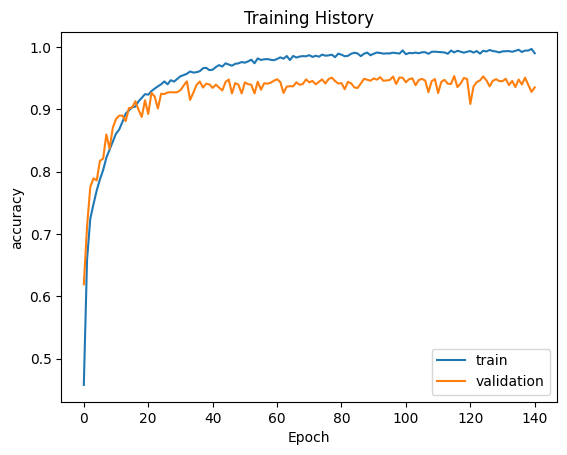

In [ ]:
# As you can see the model overfits slightly.
# With larger dropout rate the model overfitted less, but the score on test set droped too.
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.title('Training History'),
plt.xlabel('Epoch'),
plt.ylabel('accuracy')
plt.show()

Saving the model

In [ ]:
model.save('eurosat_model.keras')

In [ ]:
# new_model = tf.keras.models.load_model('eurosat_model.keras')

Making predictions

In [ ]:
model.predict(test_set)

126/126 [==============================] - 0s 3ms/step


array([[2.8816113e-10, 5.7528774e-07, 1.5387570e-10, ..., 9.4593082e-26,
        2.6339346e-22, 9.9999940e-01],
       [3.2069278e-05, 2.0083528e-20, 1.6500991e-12, ..., 8.4648688e-21,
        2.0770785e-09, 9.9996793e-01],
       [7.1112916e-10, 6.3669854e-18, 2.8437765e-20, ..., 3.4653625e-22,
        2.0938097e-11, 4.1702233e-10],
       ...,
       [1.7076761e-06, 3.2738498e-19, 8.7078581e-13, ..., 3.6535739e-23,
        6.4548946e-17, 9.9999833e-01],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        1.1652446e-23, 0.0000000e+00],
       [1.3134188e-04, 1.2047666e-10, 8.6856524e-08, ..., 4.1273037e-21,
        3.3145788e-14, 9.9986851e-01]], dtype=float32)